In [17]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Estilos
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    'font.family':  'serif',
    'font.size':    12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'figure.dpi':   150,
    'savefig.bbox': 'tight',
})

# Conexión a la base de datos
DB_PATH = '../../db/proyectomacro.db'
conn = sqlite3.connect(DB_PATH)

# Carga de datos
df_ot = pd.read_sql("SELECT * FROM oferta_total", conn)
df_dt = pd.read_sql("SELECT * FROM demanda_total", conn)
df_vbp_sectores=pd.read_sql("SELECT * FROM vbp_sector_2006_2014", conn)
conn.close()
df_ot=df_ot.set_index("año")
df_dt=df_dt.set_index("año")
df_vbp_sectores=df_vbp_sectores.set_index("año")
df_ot=df_ot/1000
df_dt=df_dt/1000
df_vbp_sectores=df_vbp_sectores/1000
# Unir los dataframes en uno solo por índice (año)
df = df_ot.join(df_dt['consumo_intermedio'])
# Calcular VAB (en millones de Bs 1990)
df['VAB'] = df['produccion_bruta'] - df['consumo_intermedio']

# Mostrar las primeras filas para verificar
df[['produccion_bruta', 'consumo_intermedio', 'VAB']].head()



,produccion_bruta,consumo_intermedio,VAB
año,,,
1988,20977.728,9914.547,11063.181
1989,21871.336,10373.324,11498.012
1990,23058.297,11103.102,11955.195
1991,24391.850,11877.886,12513.964
1992,24854.986,12134.475,12720.511


In [18]:
print("Columnas en df_ot:")
print(df_ot.columns)
print("Columnas en df_dt:")
print(df_dt.columns)



Columnas en df_ot:
Index(['oferta_total', 'produccion_bruta', 'importaciones', 'derechos_imp',
       'impuestos_ind', 'margenes_transp'],
      dtype='object')
Columnas en df_dt:
Index(['demanda_total', 'consumo_intermedio', 'consumo_final', 'fbcf',
       'variacion_existencias', 'exportaciones_bienes_serv'],
      dtype='object')


In [19]:
def add_year_value_annotations(
    ax,
    df,
    years: list[int],
    columnas: list[str],
    annotation_offsets: dict[str, dict[int, tuple[float, float]]],
    colors: dict[str, str],
    *,
    value_fmt: str = "{:,.0f}",
    arrow_lw: float = 1.1,
    text_kwargs: dict | None = None,
    arrowprops_extra: dict | None = None,
):
    """
    Anota los valores de cada sector en los años especificados.

    Parámetros
    ----------
    ax : matplotlib.axes.Axes
        El eje donde se añaden las anotaciones.
    df : pandas.DataFrame
        Índice de años, columnas = columnas (columna interna de cada tupla).
    years : list[int]
        Años que se desean anotar.
    columnas: list[str],
        Lista (en el mismo orden que se ploteó) con nombre de columna.
    annotation_offsets : dict[str, dict[int, (dx, dy)]]
        Offsets de texto personalizados: {col: {año: (dx, dy)}}.
    colors : dict[str, str]
        {col: color_hex} para cada sector.
    value_fmt : str, opcional
        Formato del texto numérico.
    arrow_lw : float, opcional
        Grosor de la línea flecha.
    text_kwargs : dict, opcional
        kwargs adicionales para `ax.annotate` (fontsize, ha, etc.).
    arrowprops_extra : dict, opcional
        Opciones adicionales para arrowprops que se combinan con arrow_lw.

    Ejemplo de uso
    --------------
    from graficos_utils import add_year_value_annotations
    add_year_value_annotations(ax, df, anot_years, columnas,
                               annotation_offsets, custom_colors)
    """

    # defaults
    if text_kwargs is None:
        text_kwargs = {'ha': 'center', 'va': 'center', 'fontsize': 14}
    if arrowprops_extra is None:
        arrowprops_extra = {}

    # arrow base dict
    def arrowprops(color):
        base = dict(arrowstyle='-', color=color, lw=arrow_lw)
        base.update(arrowprops_extra)
        return base

    for yr in years:
        if yr not in df.index:
            continue

        # Ordenar valores de menor a mayor para colocar flechas "escalonadas"
        vals = [(df.loc[yr, col], col) for col in columnas]
        vals.sort(key=lambda t: t[0])
        for y, col in vals:
            dx, dy = annotation_offsets.get(col, {}).get(yr, (0, 0))
            ax.annotate(
                value_fmt.format(y),
                xy=(yr, y),
                xytext=(yr + dx, y + dy),
                arrowprops=arrowprops(colors[col]),
                color=colors[col],
                **text_kwargs
            )

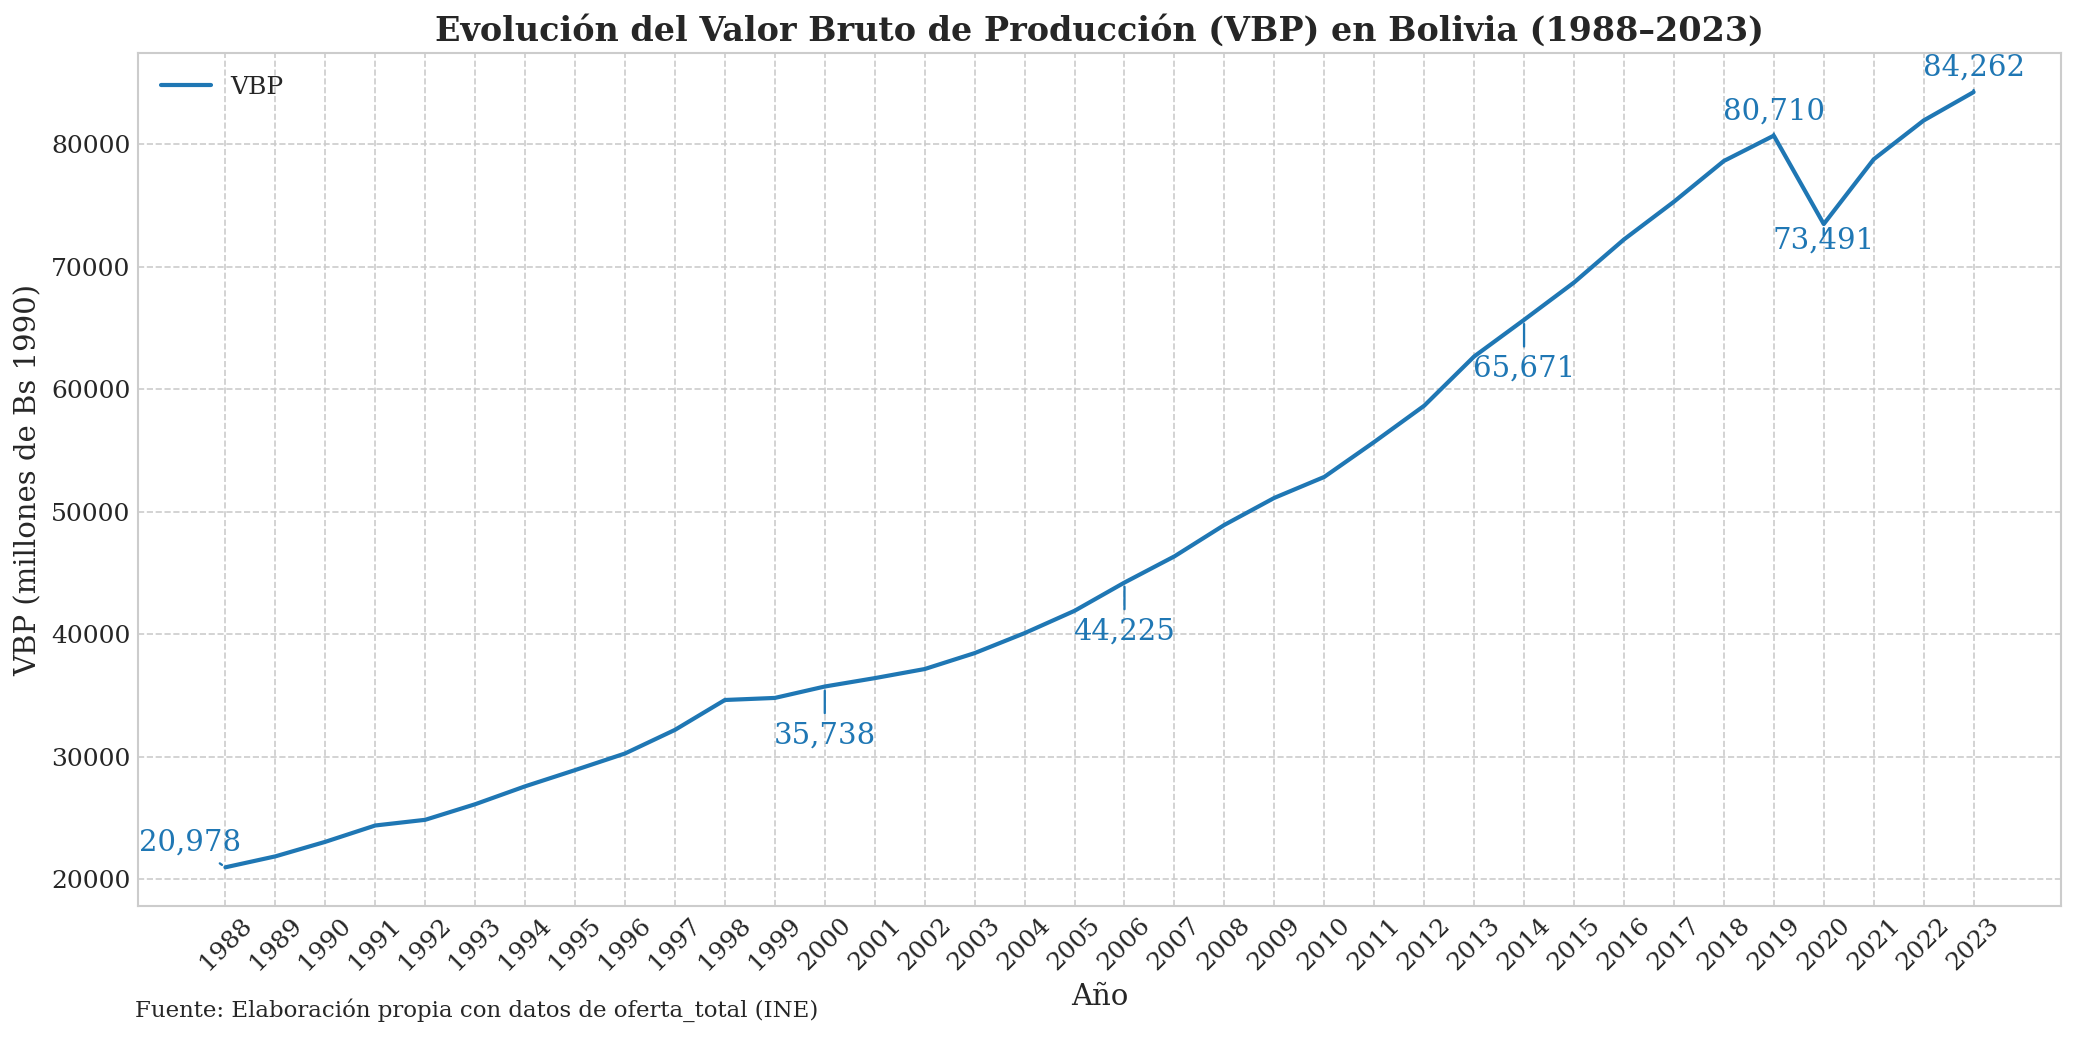

In [20]:
# ── 6. Graficar ──────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 7))

# Serie principal
ax.plot(df_ot.index, df_ot['produccion_bruta'], color='tab:blue', label='VBP')

add_year_value_annotations(
    ax,
    df_ot,
    years=[1988, 2000, 2006, 2014,2019,2020,2023],
    columnas=['produccion_bruta'],
    annotation_offsets={
        'produccion_bruta': {
            1988: (-0.7, 2000),
            2000: (0, -4000),
            2006: (0, -4000),
            2014: (0, -4000),
            2019: (0, 2000),
            2020: (0, -1300),
            2023: (0, 2000),
        }
    },
    colors={'produccion_bruta': 'tab:blue'},
)
# Etiquetas y formato
ax.set_title("Evolución del Valor Bruto de Producción (VBP) en Bolivia (1988–2023)", fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("VBP (millones de Bs 1990)")
ax.set_xticks(range(1988, 2024, 1))
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left')

# Fuente
fig.text(0.07, 0.02,
         "Fuente: Elaboración propia con datos de oferta_total (INE)",
         ha='left', fontsize=11)

plt.tight_layout()

# Guardar figura
output_dir = '.'
plt.savefig(os.path.join(output_dir, "vbp_evolution_chart.png"))
plt.show()

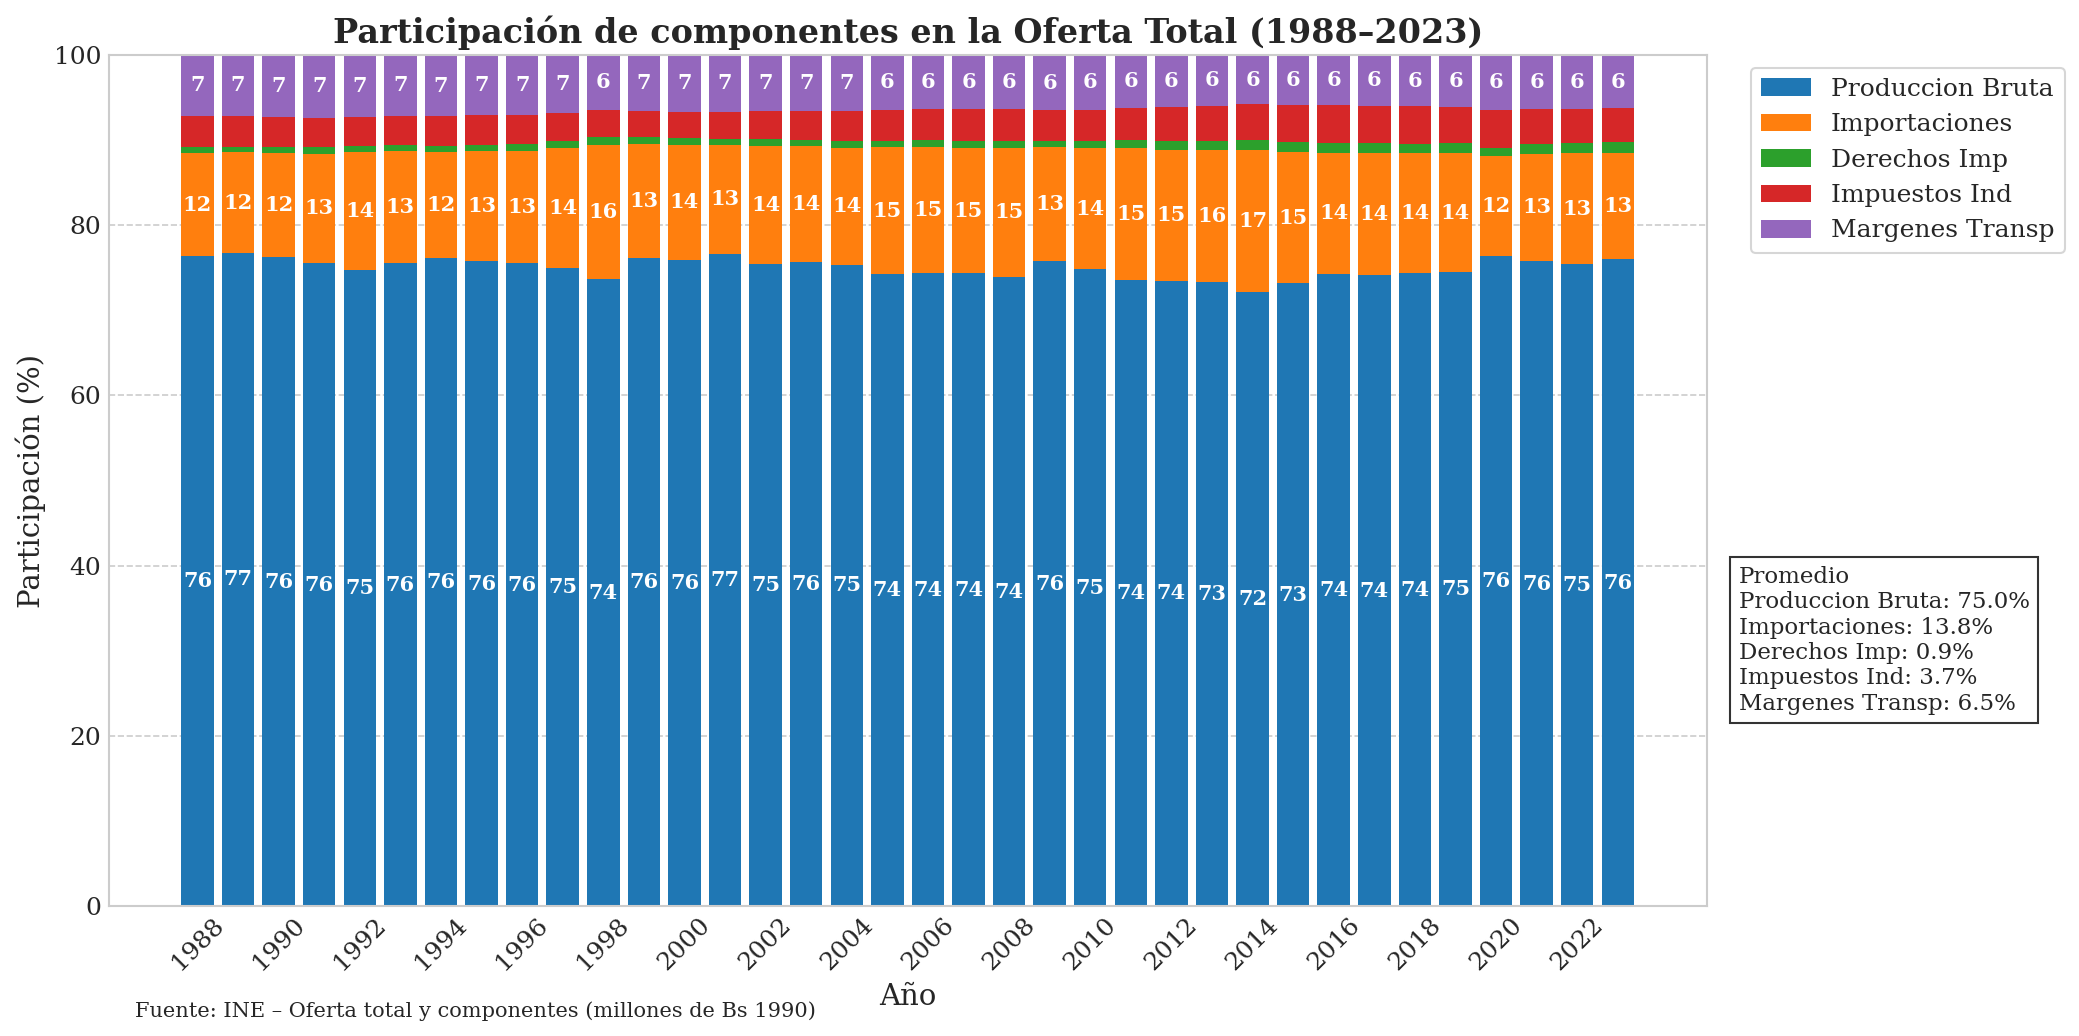

In [21]:
# ── 3. Cálculo de participaciones (%) ─────────────────────────────────────────
components = [
    'produccion_bruta',
    'importaciones',
    'derechos_imp',
    'impuestos_ind',
    'margenes_transp'
]
df_pct = df_ot[components].div(df_ot['oferta_total'], axis=0) * 100

# Estadísticas promedio de participación durante todo el período
avg_shares = df_pct.mean().round(1)

# ── 4. Gráfico stacked-bar con espacio para leyenda y estadísticas ───────────
fig, ax = plt.subplots(figsize=(14, 7))

bottom = np.zeros(len(df_pct))
colors = plt.get_cmap('tab20').colors
for i, comp in enumerate(components):
    values = df_pct[comp].values
    bars = ax.bar(df_pct.index, values, bottom=bottom,
                  label=comp.replace('_',' ').title(),
                  color=colors[2*i])
    # Anotar valor de cada segmento
    for bar, pct in zip(bars, values):
        if comp not in ['derechos_imp', 'impuestos_ind'] and pct >= 2.5:
            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_y() + pct / 2
            ax.text(
                x, y,
                f"{pct:.0f}",
                ha='center', va='center',
                color='white', fontsize=10, fontweight='bold'
            )
    bottom += values

# Ajustar márgenes para la leyenda y estadísticas
fig.subplots_adjust(right=0.8)

# ── 5. Etiquetas y formato ────────────────────────────────────────────────────
ax.set_title("Participación de componentes en la Oferta Total (1988–2023)", fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Participación (%)")
ax.set_ylim(0, 100)
ax.set_xticks(range(1988, 2024, 2))
ax.tick_params(axis='x', rotation=45)

# Leyenda fuera del área de la gráfica
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True)

# ── 6. Cuadro de estadísticas promedio ────────────────────────────────────────
stats_text = "\n".join([
    f"{comp.replace('_',' ').title()}: {avg_shares[comp]}%"
    for comp in components
])
ax.text(1.02, 0.40, "Promedio\n" + stats_text,
        transform=ax.transAxes,
        fontsize=11,
        va='top',
        ha='left',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))

# ── 7. Fuente bajo la gráfica ─────────────────────────────────────────────────
fig.text(0.07, 0.02,
         "Fuente: INE – Oferta total y componentes (millones de Bs 1990)",
         ha='left', fontsize=10)

# ── 8. Guardar y mostrar ──────────────────────────────────────────────────────
OUTPUT_DIR = "."
os.makedirs(OUTPUT_DIR, exist_ok=True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "participacion_oferta_total.png"))
plt.show()

In [29]:
df_ot.loc[2006:2016]

,oferta_total,produccion_bruta,importaciones,derechos_imp,impuestos_ind,margenes_transp
año,,,,,,
2006,59441.185,44225.362,8811.963,455.416,2189.366,3759.078
2007,62353.656,46362.892,9197.256,476.649,2333.489,3983.371
2008,66193.814,48929.539,10064.984,506.269,2497.833,4195.190
2009,67497.263,51135.817,9037.440,514.541,2430.964,4378.501
2010,70633.049,52846.736,10035.269,636.149,2564.114,4550.780
2011,75757.163,55699.751,11742.291,767.982,2832.041,4715.098
2012,79805.198,58658.410,12244.967,807.980,3201.038,4892.802
2013,85447.625,62679.464,13246.528,918.087,3518.447,5085.099
2014,91034.881,65670.823,15244.475,997.441,3840.219,5281.922


In [33]:
# 1️⃣  Etiquetamos las columnas por sector
cols_primario = [
    "productos_agricolas_no_industriales",
    "productos_agricolas_industriales",
    "coca",
    "productos_pecuarios",
    "silvicultura_caza_y_pesca",
    "petroleo_crudo_y_gas_natural",
    "minerales_metalicos_y_no_metalicos",
]

cols_secundario = [
    # Alimentos y bebidas
    "carnes_frescas_y_elaboradas",
    "productos_lacteos",
    "productos_de_molineria_y_panaderia",
    "azucar_y_confiteria",
    "productos_alimenticios_diversos",
    "bebidas",
    # Otras manufacturas
    "tabaco_elaborado",
    "textiles_prendas_vestir_y_productos_del_cuero",
    "madera_y_productos_de_madera",
    "papel_y_productos_de_papel",
    "substancias_y_productos_quimicos",
    "productos_de_refinacion_del_petroleo",
    "productos_de_minerales_no_metalicos",
    "productos_basicos_de_metales",
    "productos_metalicos_maquinaria_y_equipo",
    "productos_manufacturados_diversos",
]

cols_terciario = [
    "electricidad_gas_y_agua",
    "construccion",
    "comercio",
    "transporte_y_almacenamiento",
    "comunicaciones",
    "servicios_financieros",
    "servicios_a_las_empresas",
    "propiedad_de_vivienda",
    "servicios_comunales_sociales_y_personales",
    "restaurantes_y_hoteles",
    "servicios_domesticos",
    "servicios_de_la_administracion_publica",
]

# 2️⃣  (Opcional) Comprobamos que no falte ninguna columna
missing = set(cols_primario + cols_secundario + cols_terciario) - set(df_vbp_sectores.columns)
if missing:
    raise KeyError(f"Columnas no halladas en la tabla: {missing}")

# 3️⃣  Calculamos las agregaciones sectoriales
df_sectorales = pd.DataFrame(index=df_vbp_sectores.index)
df_sectorales["sector_primario"]   = df_vbp_sectores[cols_primario].sum(axis=1)
df_sectorales["sector_secundario"] = df_vbp_sectores[cols_secundario].sum(axis=1)
df_sectorales["sector_terciario"]  = df_vbp_sectores[cols_terciario].sum(axis=1)
# df_sectorales contiene sector_primario, sector_secundario, sector_terciario
total_vbp        = df_sectorales.sum(axis=1)
participaciones  = df_sectorales.div(total_vbp, axis=0)      # de 0 a 1
participaciones *= 100                                       # en %
print(participaciones)

      sector_primario  sector_secundario  sector_terciario
año                                                       
2006        21.024848          30.321264         48.653888
2007        20.599822          30.371450         49.028728
2008        21.626929          29.613407         48.759664
2009        20.640414          29.673563         49.686022
2010        20.160838          29.288473         50.550689
2011        19.997172          28.760303         51.242525
2012        20.031241          28.731466         51.237293
2013        20.183735          28.529283         51.286982
2014        19.351223          28.063077         52.585700


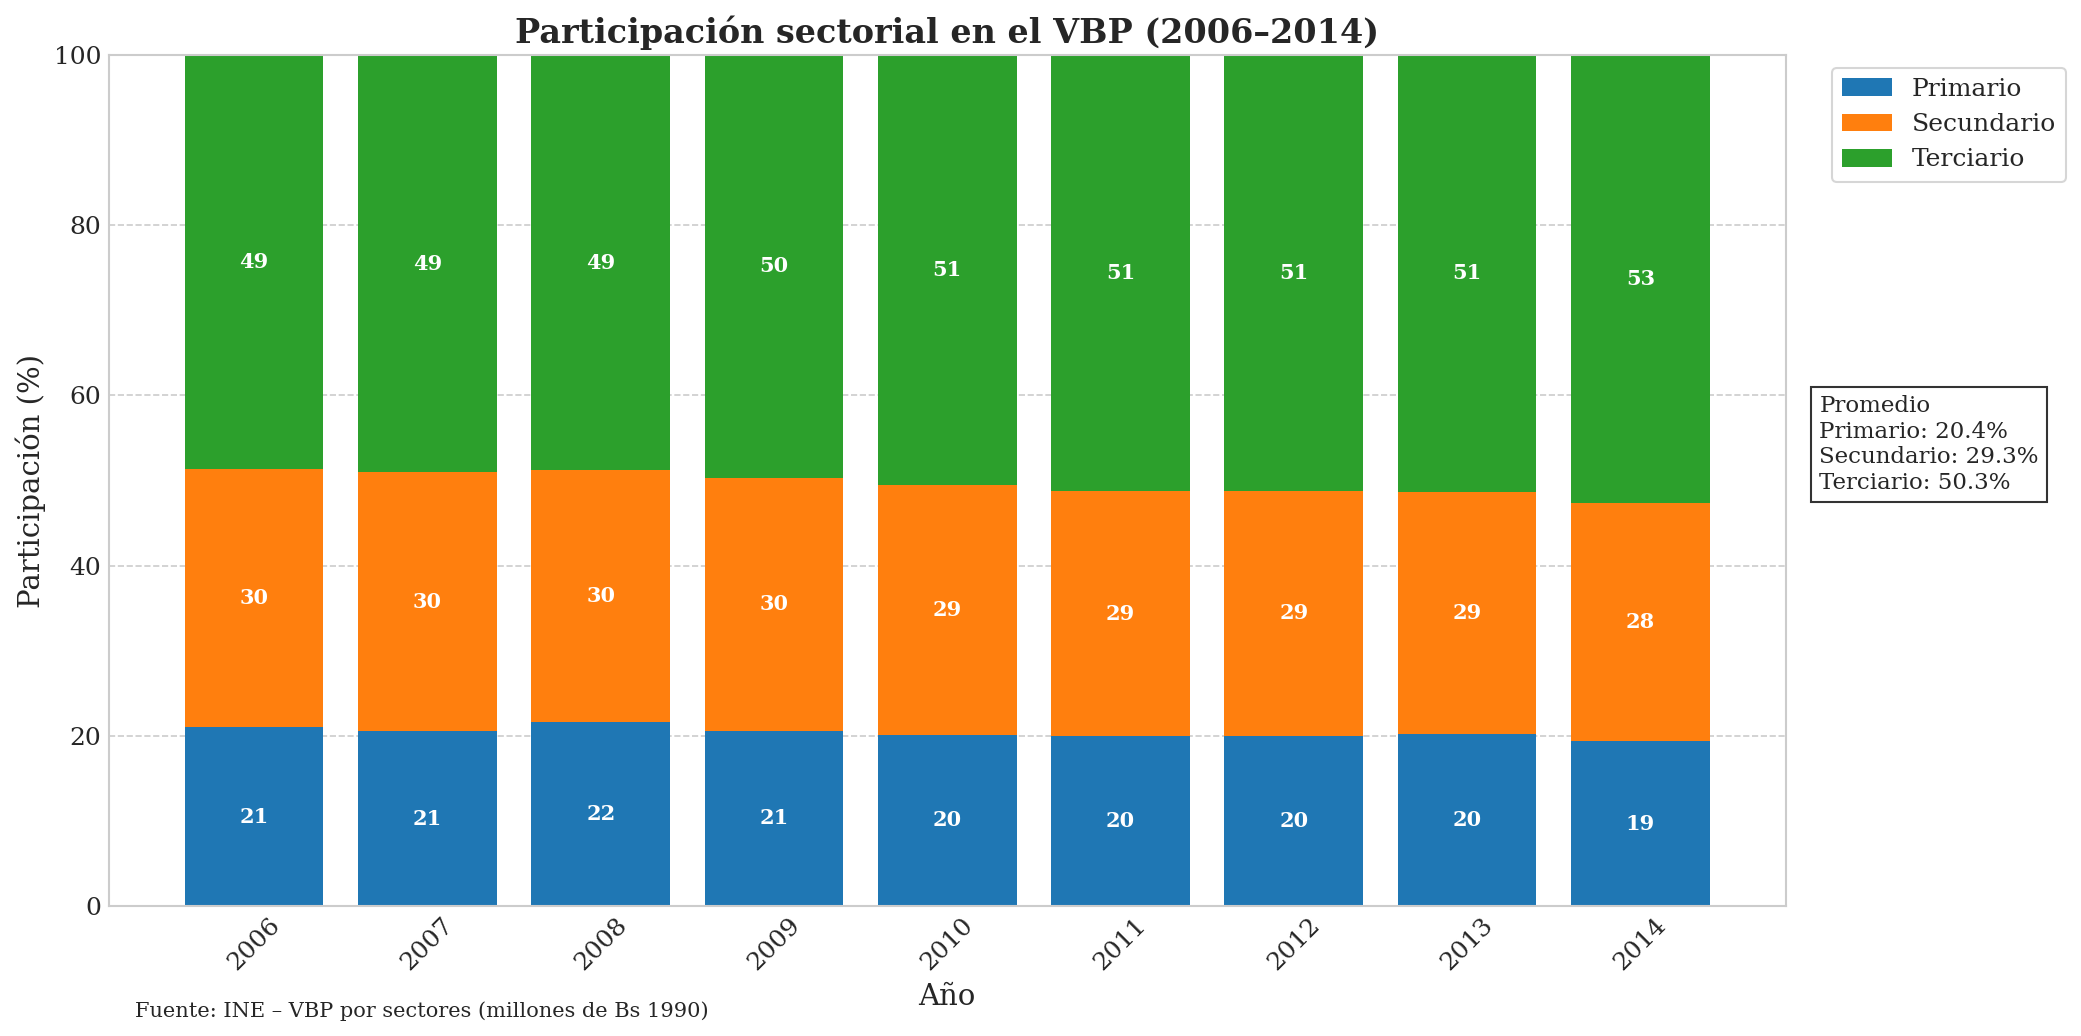

In [32]:
# ── 3. Cálculo de participaciones (%) ─────────────────────────────────────────
components = [
    'sector_primario',
    'sector_secundario',
    'sector_terciario'
]
df_pct = participaciones[components]  # ya está en %

# Estadísticas promedio de participación durante todo el período
avg_shares = df_pct.mean().round(1)

# ── 4. Gráfico stacked-bar con espacio para leyenda y estadísticas ───────────
fig, ax = plt.subplots(figsize=(14, 7))

bottom = np.zeros(len(df_pct))
colors = plt.get_cmap('tab20').colors
for i, comp in enumerate(components):
    values = df_pct[comp].values
    bars = ax.bar(df_pct.index, values, bottom=bottom,
                  label=comp.replace('sector_','').title(),
                  color=colors[2*i])
    # Anotar valor de cada segmento
    for bar, pct in zip(bars, values):
        if pct >= 2.5:
            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_y() + pct / 2
            ax.text(
                x, y,
                f"{pct:.0f}",
                ha='center', va='center',
                color='white', fontsize=10, fontweight='bold'
            )
    bottom += values

# Ajustar márgenes para la leyenda y estadísticas
fig.subplots_adjust(right=0.8)

# ── 5. Etiquetas y formato ────────────────────────────────────────────────────
ax.set_title("Participación sectorial en el VBP (2006–2014)", fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Participación (%)")
ax.set_ylim(0, 100)
ax.set_xticks(df_pct.index)
ax.tick_params(axis='x', rotation=45)

# Leyenda fuera del área de la gráfica
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True)

# ── 6. Cuadro de estadísticas promedio ────────────────────────────────────────
stats_text = "\n".join([
    f"{comp.replace('sector_','').title()}: {avg_shares[comp]}%"
    for comp in components
])
ax.text(1.02, 0.60, "Promedio\n" + stats_text,
        transform=ax.transAxes,
        fontsize=11,
        va='top',
        ha='left',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))

# ── 7. Fuente bajo la gráfica ─────────────────────────────────────────────────
fig.text(0.07, 0.02,
         "Fuente: INE – VBP por sectores (millones de Bs 1990)",
         ha='left', fontsize=10)

# ── 8. Guardar y mostrar ──────────────────────────────────────────────────────
OUTPUT_DIR = "."
os.makedirs(OUTPUT_DIR, exist_ok=True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "participacion_vbp_sectores.png"))
plt.show()